In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from dysts.base import DynSys
from scipy.integrate import solve_ivp

from dystformer.augmentations import StandardizeTransform
from dystformer.chronos.pipeline import ChronosPipeline
from dystformer.patchtst.pipeline import PatchTSTPipeline

/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer_jeff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class KuramotoShivashinsky(DynSys):
    """Implements the 1+1D KS equation in fourier space"""

    def __init__(self, L: float, modes: int, dt: float = 1e-1):
        super().__init__(metadata_path=None, dt=dt, dimension=2 * modes, parameters={})
        self.L = L
        self.modes = modes
        self.dimension = 2 * self.modes
        self.wave_nums = 2 * np.pi * np.arange(0, self.modes + 2) / self.L
        self.N = self.dimension + 2

        # precompute some quantities
        self.freq_domain = np.zeros(self.modes + 2, dtype=np.complex128)
        self.nonlinear_factor = -0.5 * 1j * self.wave_nums * self.N
        self.diffusion_ffts = self.wave_nums**2 - self.wave_nums**4

    def to_spatial(self, q: np.ndarray, N: int) -> np.ndarray:
        """Inverse FFT of the modes to get u(x) at a certain time

        :param q: array of flattened fourier coefficients (real and imag components), can have batch dimensions
        :param N: grid resolution in the spatial domain

        :returns: solution in the spatial domain
        """
        coeffs = np.zeros(q.shape[:-1] + (self.modes + 2,), dtype=complex)
        coeffs[..., 1:-1] = q[..., : self.modes] + 1j * q[..., self.modes :]
        return np.fft.irfft(coeffs, n=N)

    def rhs(self, t: float, X: np.ndarray) -> np.ndarray:
        self.freq_domain[1:-1] = X[: self.modes] + 1j * X[self.modes :]
        u = np.fft.irfft(self.freq_domain, n=self.N)
        pseudospectral_term = self.nonlinear_factor * np.fft.rfft(u * u)
        linear_term = self.diffusion_ffts * self.freq_domain

        # repackage components
        flow = (linear_term + pseudospectral_term)[1:-1]
        return np.concatenate([np.real(flow), np.imag(flow)])


In [3]:
ks = KuramotoShivashinsky(L=200, modes=100)

ic = 0.1 * np.random.normal(size=(ks.dimension,))
teval = np.linspace(0, 100, 8192)
sol = solve_ivp(
    ks.rhs, (0, 100), ic, method="DOP853", t_eval=teval, rtol=1e-8, atol=1e-8
)
ts, freq_traj = sol.t, sol.y.T
spatial_traj = ks.to_spatial(freq_traj, N=ks.dimension)

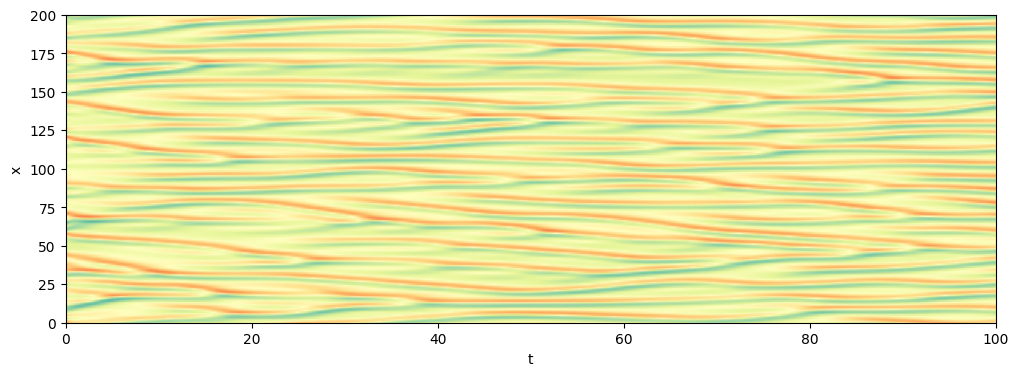

In [4]:
grid = np.linspace(0, ks.L, ks.dimension)
plt.figure(figsize=(12, 4))
plt.pcolormesh(ts, grid, spatial_traj.T, cmap="Spectral", shading="gouraud")
plt.ylabel("x")
plt.xlabel("t")
plt.show()


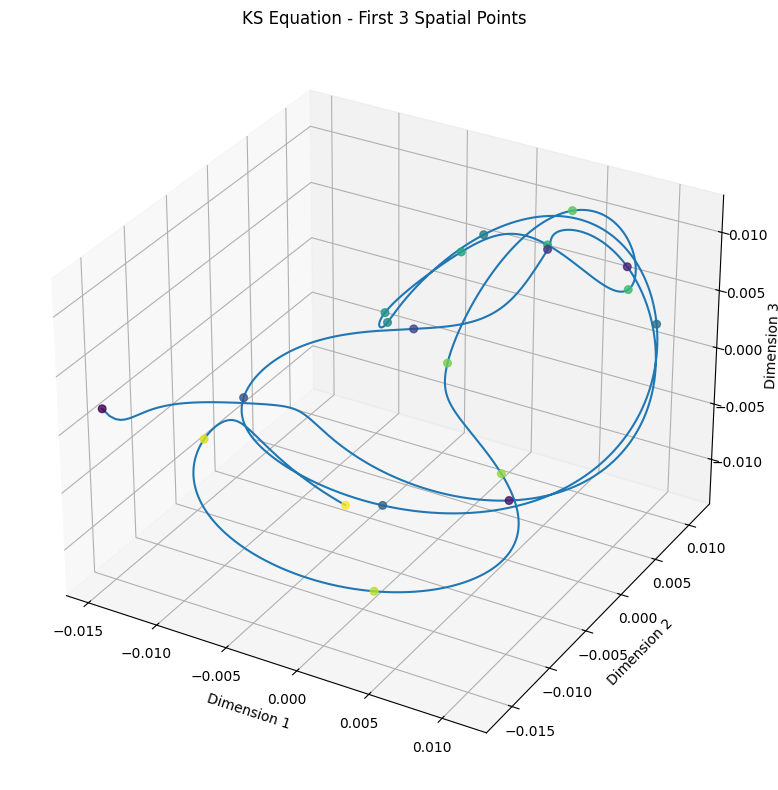

In [5]:
def plot_3d_trajectory(
    trajectory: np.ndarray,
    title: str = "3D Trajectory",
    figsize: tuple[int, int] = (12, 8),
) -> None:
    """Plot the first three dimensions of a trajectory in 3D space.

    Args:
        trajectory: Array of shape (T, D) where T is time steps and D is dimensions
        title: Plot title
        figsize: Figure size in inches (width, height)
    """
    if trajectory.shape[1] < 3:
        raise ValueError(
            f"Trajectory must have at least 3 dimensions, but has {trajectory.shape[1]}"
        )

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the trajectory
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])

    # Add scatter points to show direction
    n_points = min(20, len(trajectory))
    indices = np.linspace(0, len(trajectory) - 1, n_points, dtype=int)
    colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))

    ax.scatter(
        trajectory[indices, 0],
        trajectory[indices, 1],
        trajectory[indices, 2],
        c=colors,
        s=30,
        alpha=0.8,
    )

    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


# Example: Plot the first 1000 time steps using the first 3 spatial points
plot_3d_trajectory(spatial_traj, title="KS Equation - First 3 Spatial Points")

In [6]:
pipeline = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path="/stor/work/AMDG_Gilpin_Summer2024/checkpoints/pft_chattn_noembed_pretrained_correct-0/checkpoint-final",
    device_map="cuda:0",
    torch_dtype=torch.float32,
)
pipeline

PatchTSTPipeline(mode='predict', model=PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=16, out_features=512, bias=True)
      )
      (layers): ModuleList(
        (0-7): 8 x PatchTSTEncoderLayerWithRope(
          (temporal_self_attn): PatchTSTRopeAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (channel_self_attn): PatchTSTRopeAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, 

In [7]:
def forecast(
    pipeline,
    trajectory: np.ndarray,
    context_length: int,
    normalize: bool = True,
    transpose: bool = False,
    prediction_length: int | None = None,
    **kwargs,
) -> np.ndarray:
    context = trajectory[:context_length]
    if normalize:
        normalizer = StandardizeTransform()
        context = normalizer(context, axis=0)

    if prediction_length is None:
        prediction_length = trajectory.shape[0] - context_length

    if transpose:
        context = context.T

    predictions = (
        pipeline.predict(
            context=torch.tensor(context).float(),
            prediction_length=prediction_length,
            limit_prediction_length=False,
            **kwargs,
        )
        .squeeze()
        .cpu()
        .numpy()
    )
    full_trajectory = np.concatenate([context, predictions], axis=1 if transpose else 0)

    if transpose:
        full_trajectory = full_trajectory.T

    if normalize:
        return normalizer(
            full_trajectory,
            axis=0,
            context=trajectory[:context_length],
            denormalize=True,
        )

    return full_trajectory


def plot_forecast(
    ts: np.ndarray,
    grid: np.ndarray,
    trajectory: np.ndarray,
    predictions: np.ndarray,
):
    fig, axes = plt.subplots(3, 1, figsize=(12, 6))

    for ax, data, label in zip(
        axes,
        [trajectory, predictions, predictions - trajectory],
        ["Ground Truth", "Predictions", "Prediction Error"],
    ):
        im = ax.pcolormesh(ts, grid, data.T, cmap="Spectral", shading="gouraud")
        ax.set_xlabel("t")
        ax.set_ylabel("L")
        ax.set_title(label)
        fig.colorbar(im, ax=ax)

    plt.tight_layout()

In [8]:
# predict in frequency domain
predictions = forecast(
    pipeline,
    freq_traj,
    512,
    prediction_length=512,
    normalize=True,
    sliding_context=True,
)

# convert to spatial domain
spatial_predictions = ks.to_spatial(predictions, N=ks.dimension)

/stor/home/jl82436/dystformer/dystformer/patchtst/pipeline.py:217: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


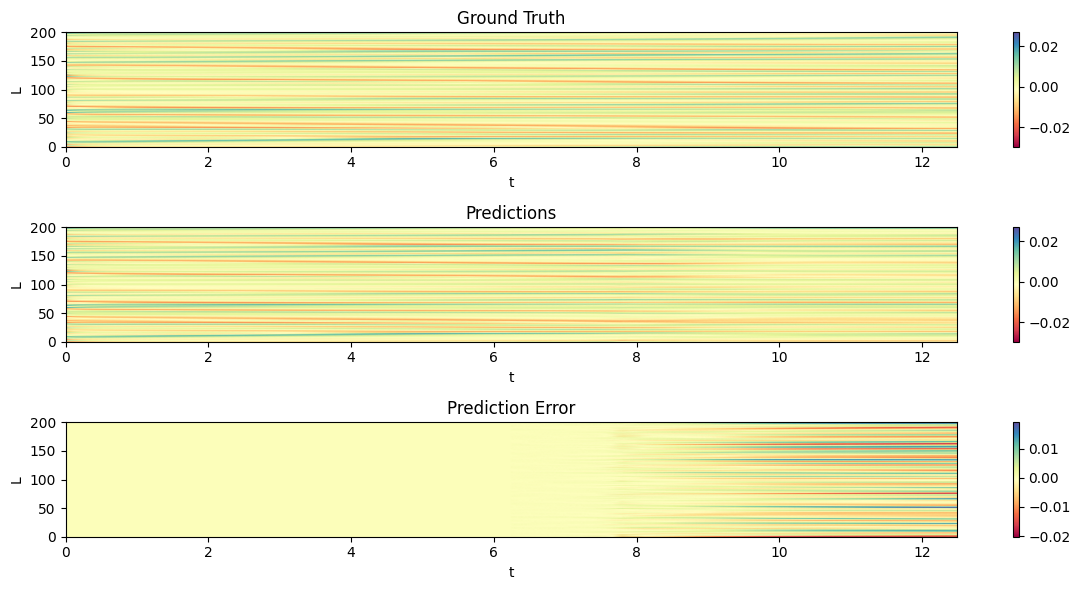

In [9]:
plot_forecast(ts[:1024], grid, spatial_traj[:1024], spatial_predictions)


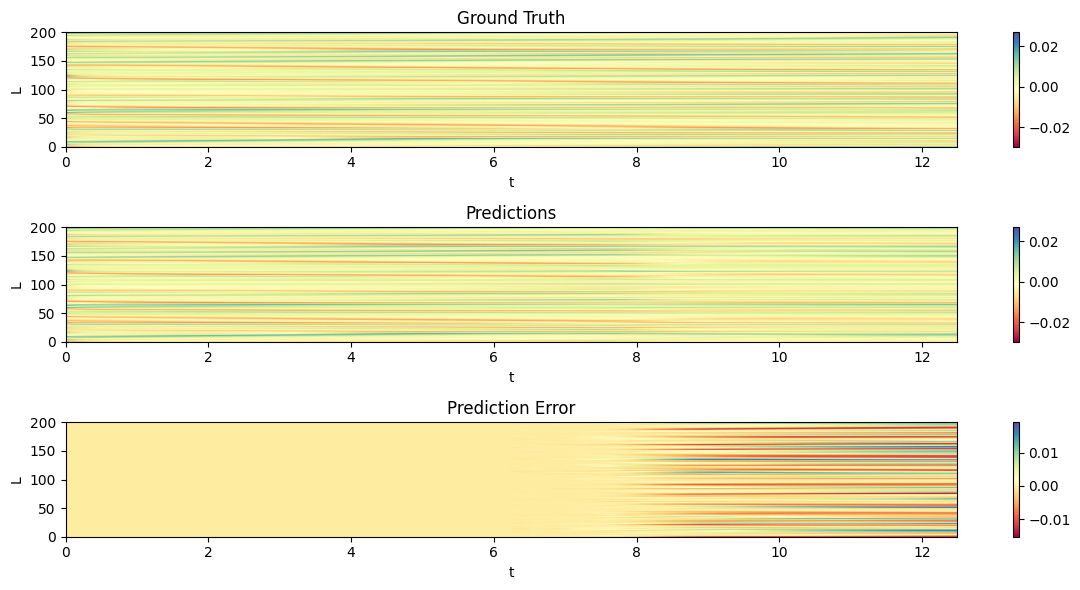

In [ ]:
# predict in spatial domain
predictions = forecast(
    pipeline,
    spatial_traj,
    512,
    prediction_length=512,
    normalize=True,
    sliding_context=True,
)
plot_forecast(ts[:1024], grid, spatial_traj[:1024], predictions)

In [11]:
chronos = ChronosPipeline.from_pretrained(
    "/stor/work/AMDG_Gilpin_Summer2024/checkpoints/chronos_finetune_stand_updated-0/checkpoint-final",
    device_map="cuda:1",
    torch_dtype=torch.float32,
)
chronos

ChronosPipeline(tokenizer=<dystformer.chronos.tokenizer.MeanScaleUniformBins object at 0x7f6a601da510>, model=ChronosModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(4096, 384)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 384)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=384, out_features=512, bias=False)
                (k): Linear(in_features=384, out_features=512, bias=False)
                (v): Linear(in_features=384, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=384, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
        

In [12]:
from tqdm import trange

# predict in frequency domain
chunk_size = 10
subchannel_predictions = []
for i in trange(0, freq_traj.shape[1] // chunk_size):
    predictions = forecast(
        chronos,
        freq_traj[:, i * chunk_size : (i + 1) * chunk_size],
        512,
        prediction_length=512,
        transpose=True,
        normalize=False,
        num_samples=1,
    )
    subchannel_predictions.append(predictions)

predictions = np.concatenate(subchannel_predictions, axis=1)

# convert to spatial domain
chronos_spatial_predictions = ks.to_spatial(predictions, N=ks.dimension)

  0%|          | 0/20 [00:00<?, ?it/s]/stor/home/jl82436/dystformer/dystformer/chronos/pipeline.py:157: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
/stor/home/jl82436/dystformer/dystformer/chronos/tokenizer.py:180: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  torch.bucketize(
  5%|▌         | 1/20 [00:03<01:02,  3.27s/it]/stor/home/jl82436/dystformer/dystformer/chronos/pipeline.py:157: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
100%

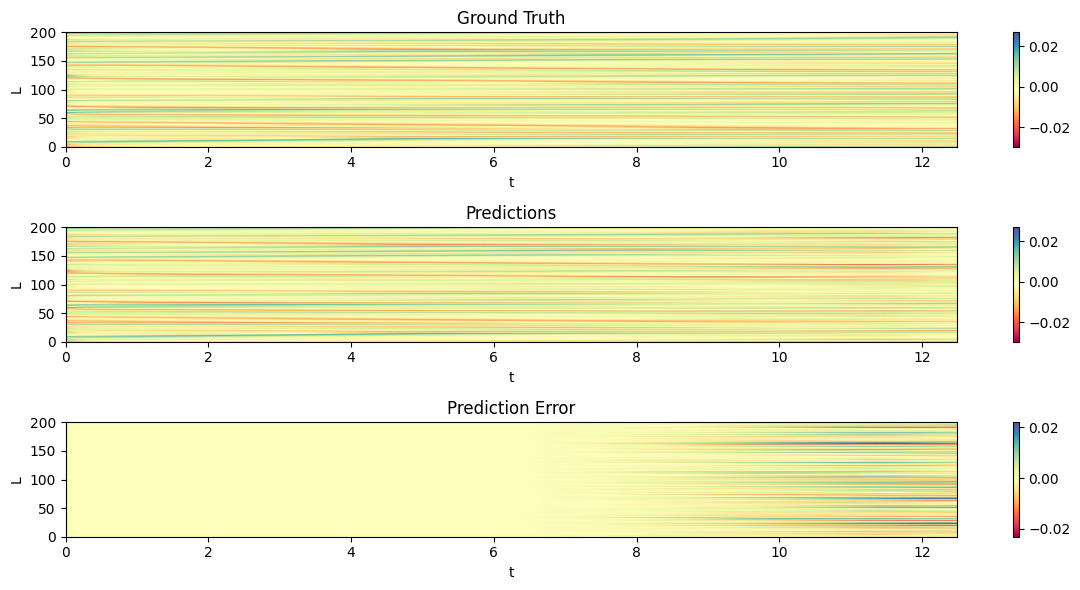

In [13]:
plot_forecast(ts[:1024], grid, spatial_traj[:1024], chronos_spatial_predictions)